In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [53]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('./data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('./data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

dir(train_dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

## Common setup

In [35]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [36]:
# Set up data loaders
batch_size = 2560 
kwargs = {'num_workers': 8, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.389927	Accuracy: 10.9765625
Epoch: 1/20. Train set: Average loss: 4.1235	Accuracy: 11.308333333333334
Epoch: 1/20. Validation set: Average loss: 2.1549	Accuracy: 17.46
Train: [0/60000 (0%)]	Loss: 2.168113	Accuracy: 16.640625
Epoch: 2/20. Train set: Average loss: 1.9900	Accuracy: 21.473333333333333
Epoch: 2/20. Validation set: Average loss: 1.7896	Accuracy: 29.69
Train: [0/60000 (0%)]	Loss: 1.794729	Accuracy: 30.0
Epoch: 3/20. Train set: Average loss: 1.5667	Accuracy: 41.63
Epoch: 3/20. Validation set: Average loss: 1.3466	Accuracy: 50.83
Train: [0/60000 (0%)]	Loss: 1.338868	Accuracy: 51.6796875
Epoch: 4/20. Train set: Average loss: 1.1328	Accuracy: 58.361666666666665
Epoch: 4/20. Validation set: Average loss: 0.9041	Accuracy: 64.12
Train: [0/60000 (0%)]	Loss: 0.936320	Accuracy: 63.3203125
Epoch: 5/20. Train set: Average loss: 0.8634	Accuracy: 67.85666666666667
Epoch: 5/20. Validation set: Average loss: 2.1767	Accuracy: 49.97
Train: [0/60000 (0%)]	Loss: 2.0

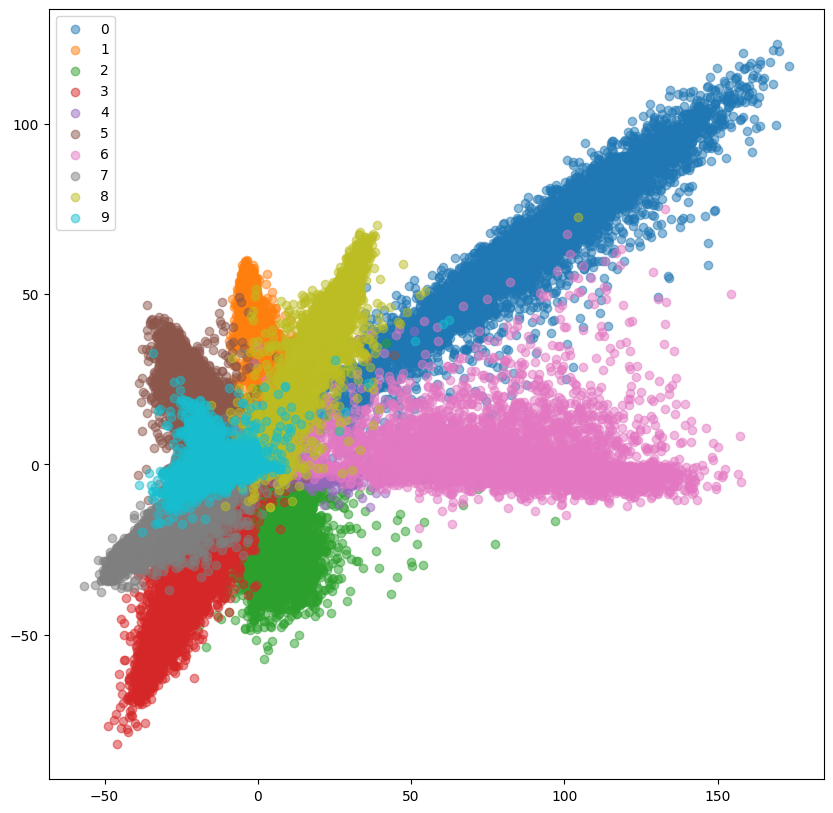

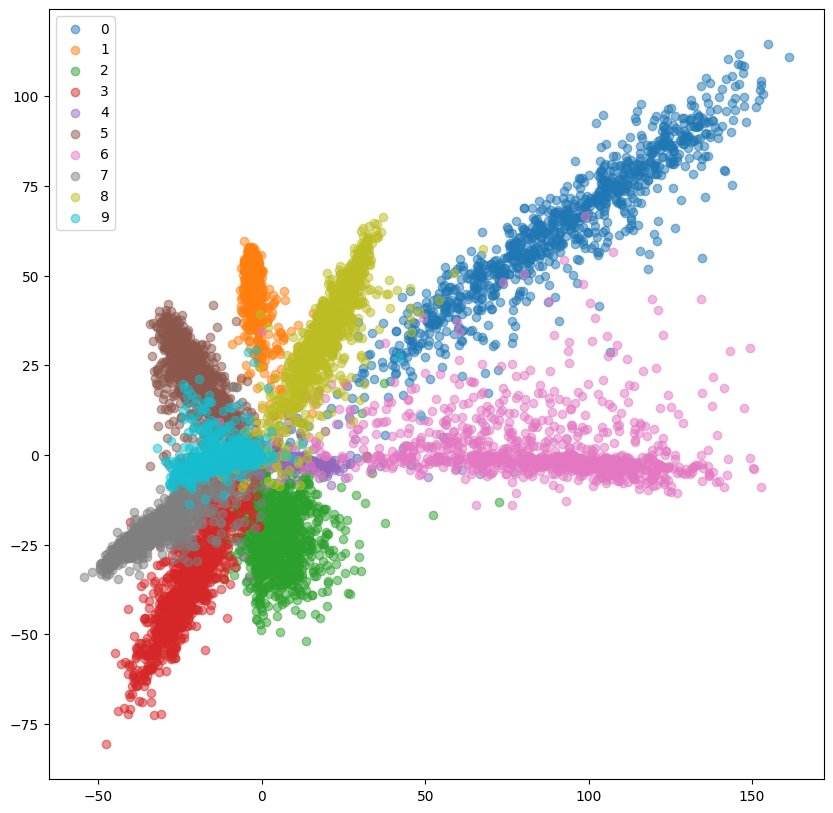

In [38]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [39]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 1280
kwargs = {'num_workers': 8, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [40]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.232284
Epoch: 1/20. Train set: Average loss: 0.0686
Epoch: 1/20. Validation set: Average loss: 0.0437
Train: [0/60000 (0%)]	Loss: 0.045769
Epoch: 2/20. Train set: Average loss: 0.0366
Epoch: 2/20. Validation set: Average loss: 0.0313
Train: [0/60000 (0%)]	Loss: 0.031359
Epoch: 3/20. Train set: Average loss: 0.0266
Epoch: 3/20. Validation set: Average loss: 0.0248
Train: [0/60000 (0%)]	Loss: 0.023612
Epoch: 4/20. Train set: Average loss: 0.0204
Epoch: 4/20. Validation set: Average loss: 0.0196
Train: [0/60000 (0%)]	Loss: 0.018947
Epoch: 5/20. Train set: Average loss: 0.0163
Epoch: 5/20. Validation set: Average loss: 0.0165
Train: [0/60000 (0%)]	Loss: 0.012648
Epoch: 6/20. Train set: Average loss: 0.0130
Epoch: 6/20. Validation set: Average loss: 0.0145
Train: [0/60000 (0%)]	Loss: 0.010201
Epoch: 7/20. Train set: Average loss: 0.0110
Epoch: 7/20. Validation set: Average loss: 0.0114
Train: [0/60000 (0%)]	Loss: 0.009224
Epoch: 8/20. Train set: Average loss: 0

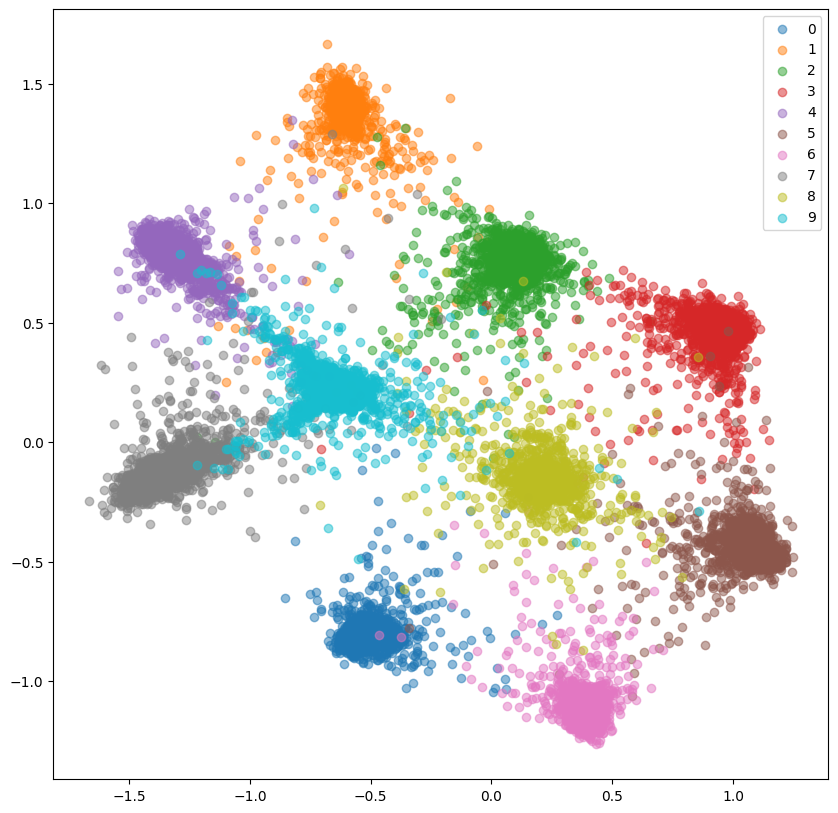

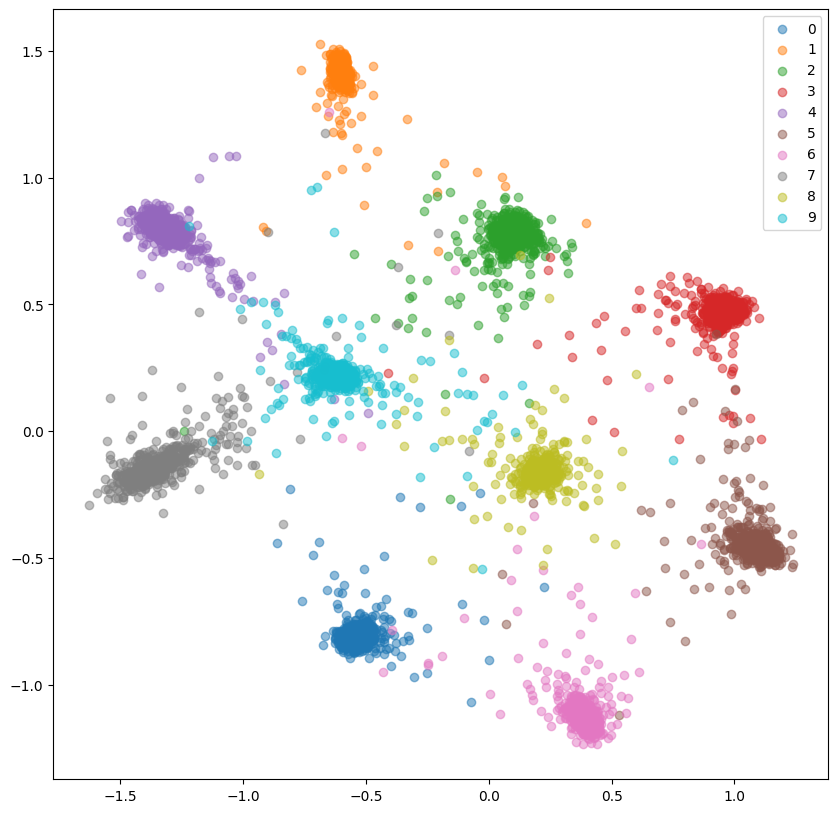

In [41]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [42]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [43]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999556
Train: [12800/60000 (21%)]	Loss: 0.297459
Train: [25600/60000 (43%)]	Loss: 0.153982
Train: [38400/60000 (64%)]	Loss: 0.113576
Train: [51200/60000 (85%)]	Loss: 0.084313
Epoch: 1/20. Train set: Average loss: 0.1514
Epoch: 1/20. Validation set: Average loss: 0.0729
Train: [0/60000 (0%)]	Loss: 0.052027
Train: [12800/60000 (21%)]	Loss: 0.063157
Train: [25600/60000 (43%)]	Loss: 0.052638
Train: [38400/60000 (64%)]	Loss: 0.047483
Train: [51200/60000 (85%)]	Loss: 0.048835
Epoch: 2/20. Train set: Average loss: 0.0513
Epoch: 2/20. Validation set: Average loss: 0.0545
Train: [0/60000 (0%)]	Loss: 0.020078
Train: [12800/60000 (21%)]	Loss: 0.038957
Train: [25600/60000 (43%)]	Loss: 0.037950
Train: [38400/60000 (64%)]	Loss: 0.030612
Train: [51200/60000 (85%)]	Loss: 0.034017
Epoch: 3/20. Train set: Average loss: 0.0346
Epoch: 3/20. Validation set: Average loss: 0.0301
Train: [0/60000 (0%)]	Loss: 0.029949
Train: [12800/60000 (21%)]	Loss: 0.024210
Train: [25600/60000 (

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "d:\python\python310\lib\multiprocessing\queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x000001C431D24EE0>
Traceback (most recent call last):
  File "d:\python\python310\lib\multiprocessing\connection.py", line 132, in __del__
    reader_close()
  File "d:\python\python310\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "d:\python\python310\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。
    self._close()
  File "d:\python\python310\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\python\python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\python\python31

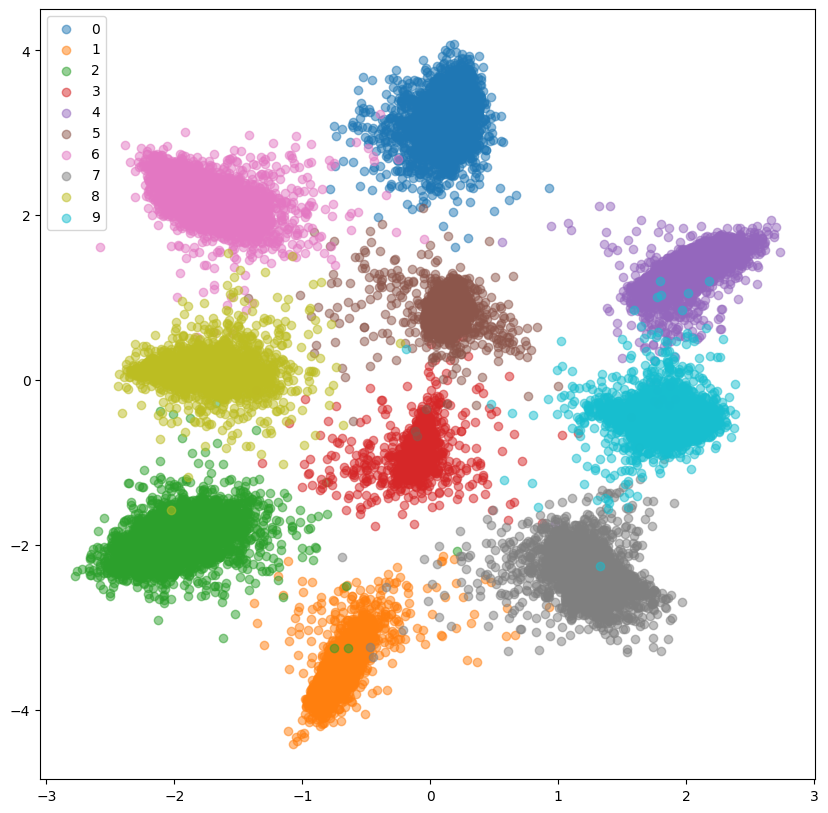

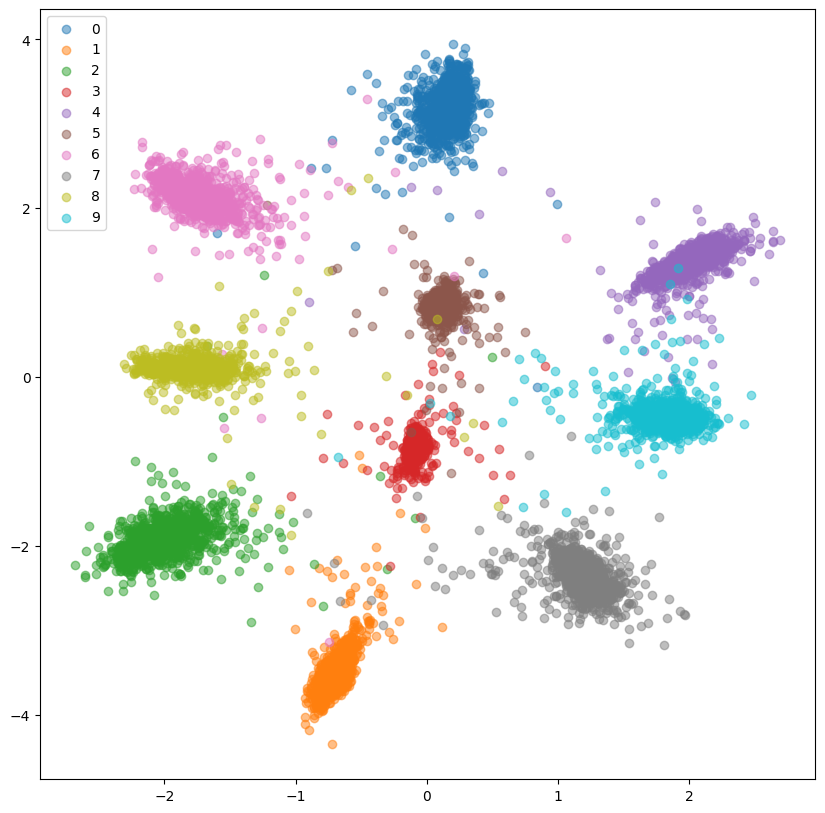

In [44]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [45]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [46]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493198
Train: [12500/60000 (21%)]	Loss: 0.291549
Train: [25000/60000 (42%)]	Loss: 0.161652
Train: [37500/60000 (62%)]	Loss: 0.109882
Train: [50000/60000 (83%)]	Loss: 0.084145
Epoch: 1/20. Train set: Average loss: 0.1490
Epoch: 1/20. Validation set: Average loss: 0.0641
Train: [0/60000 (0%)]	Loss: 0.084479
Train: [12500/60000 (21%)]	Loss: 0.053233
Train: [25000/60000 (42%)]	Loss: 0.053072
Train: [37500/60000 (62%)]	Loss: 0.045642
Train: [50000/60000 (83%)]	Loss: 0.041974
Epoch: 2/20. Train set: Average loss: 0.0474
Epoch: 2/20. Validation set: Average loss: 0.0346
Train: [0/60000 (0%)]	Loss: 0.015258
Train: [12500/60000 (21%)]	Loss: 0.027828
Train: [25000/60000 (42%)]	Loss: 0.027305
Train: [37500/60000 (62%)]	Loss: 0.026915
Train: [50000/60000 (83%)]	Loss: 0.029917
Epoch: 3/20. Train set: Average loss: 0.0275
Epoch: 3/20. Validation set: Average loss: 0.0249
Train: [0/60000 (0%)]	Loss: 0.026478
Train: [12500/60000 (21%)]	Loss: 0.024723
Train: [25000/60000 (

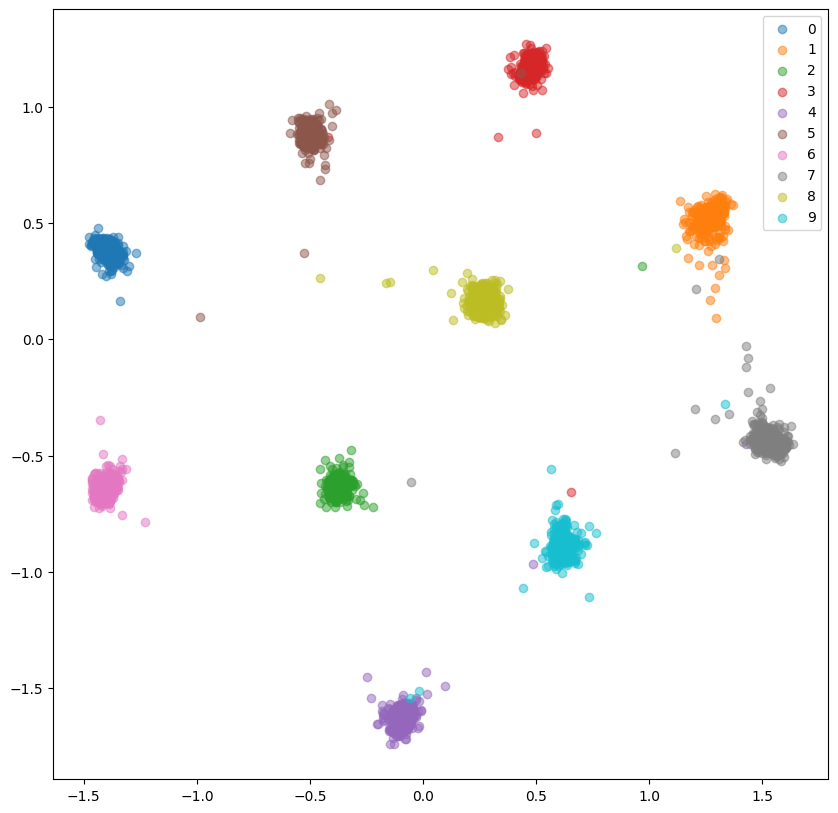

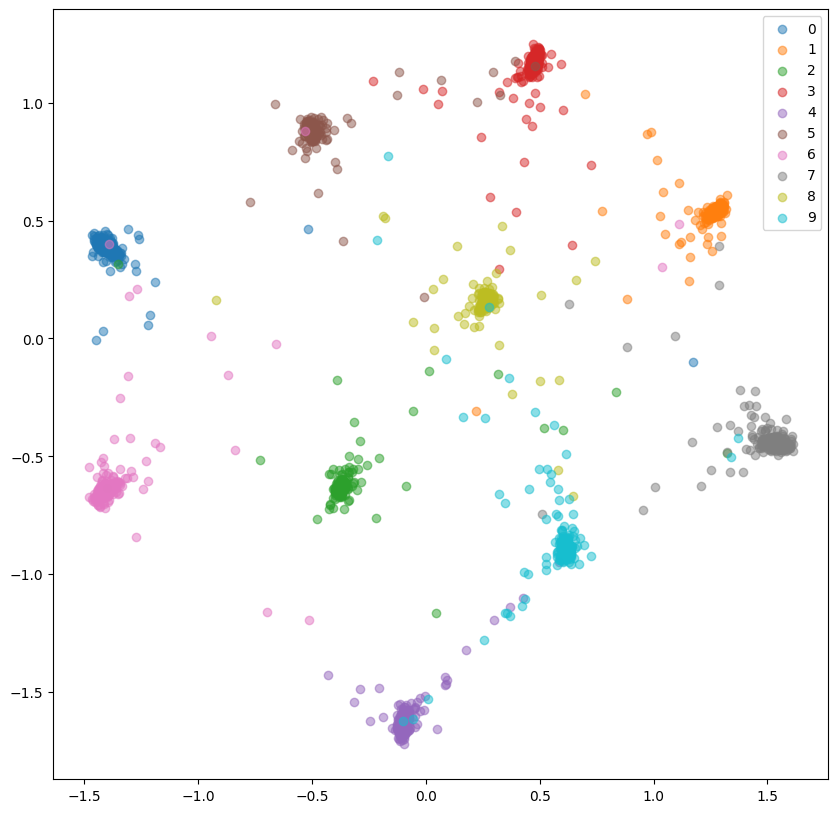

In [47]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [48]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [49]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999569	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.991512	Average nonzero triplets: 2629.3529411764707
Train: [25000/60000 (42%)]	Loss: 0.956854	Average nonzero triplets: 2315.039603960396
Train: [37500/60000 (62%)]	Loss: 0.998606	Average nonzero triplets: 2072.58940397351
Train: [50000/60000 (83%)]	Loss: 0.982211	Average nonzero triplets: 1900.363184079602
Epoch: 1/20. Train set: Average loss: 0.9829	Average nonzero triplets: 1785.4686192468619
Epoch: 1/20. Validation set: Average loss: 1.0050	Average nonzero triplets: 920.2564102564103
Train: [0/60000 (0%)]	Loss: 1.057033	Average nonzero triplets: 1540.0
Train: [12500/60000 (21%)]	Loss: 1.022515	Average nonzero triplets: 971.8235294117648
Train: [25000/60000 (42%)]	Loss: 0.970266	Average nonzero triplets: 941.8118811881188
Train: [37500/60000 (62%)]	Loss: 1.052121	Average nonzero triplets: 920.3907284768212
Train: [50000/60000 (83%)]	Loss: 1.035296	Average nonzero triplets: 879.99

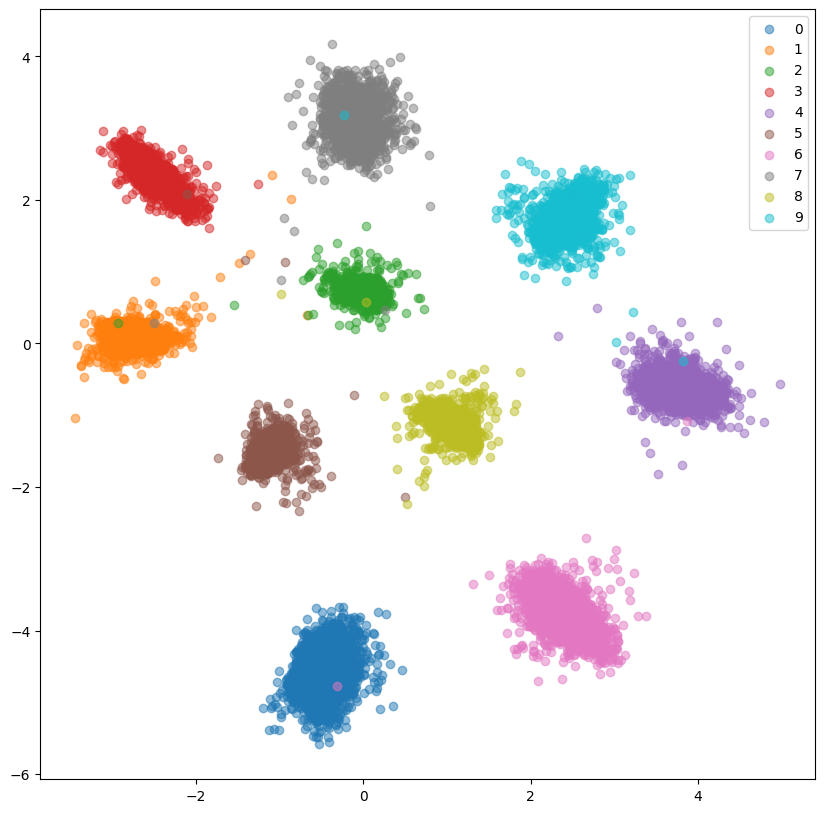

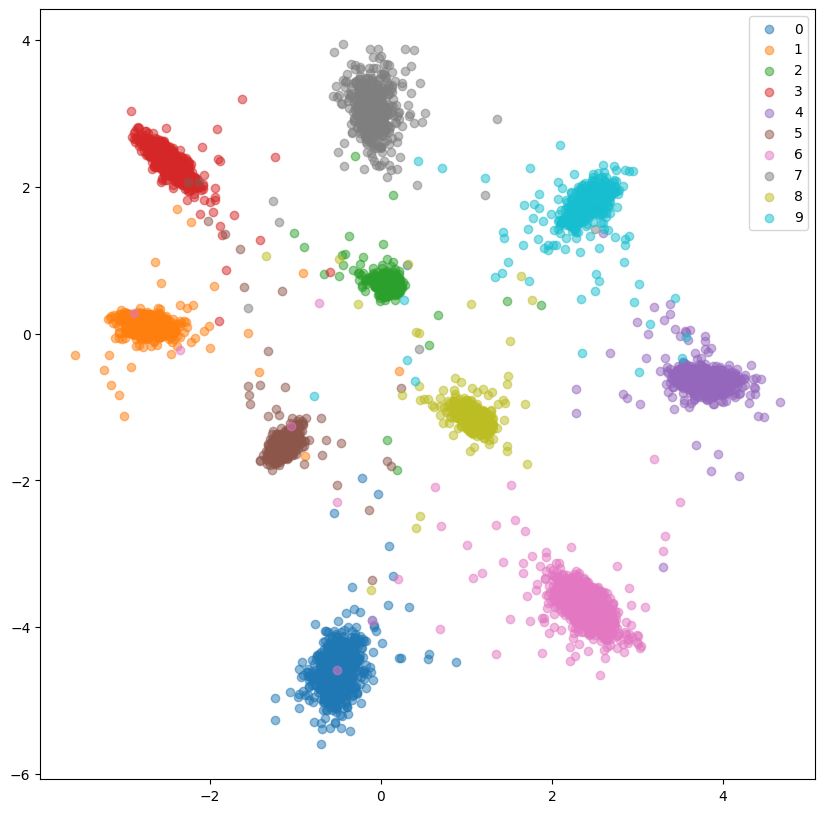

In [50]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

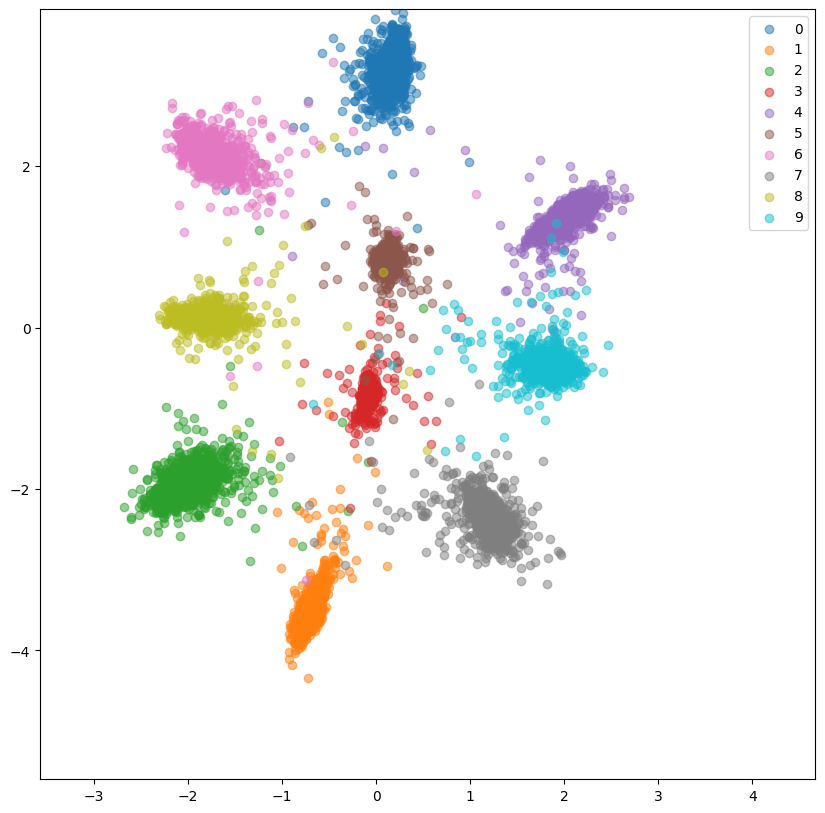

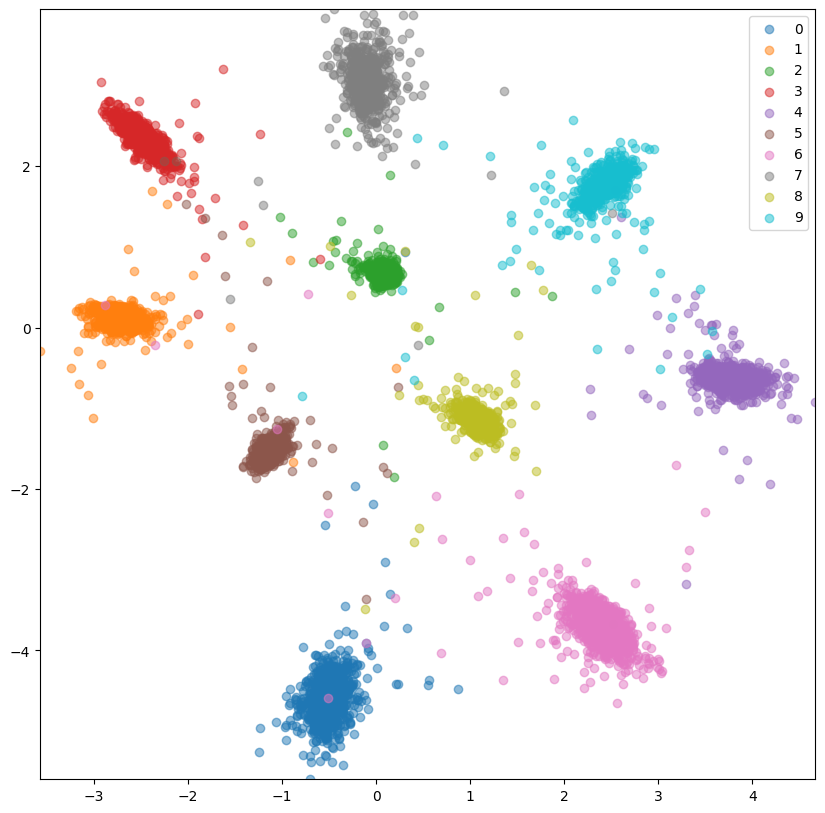

In [51]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

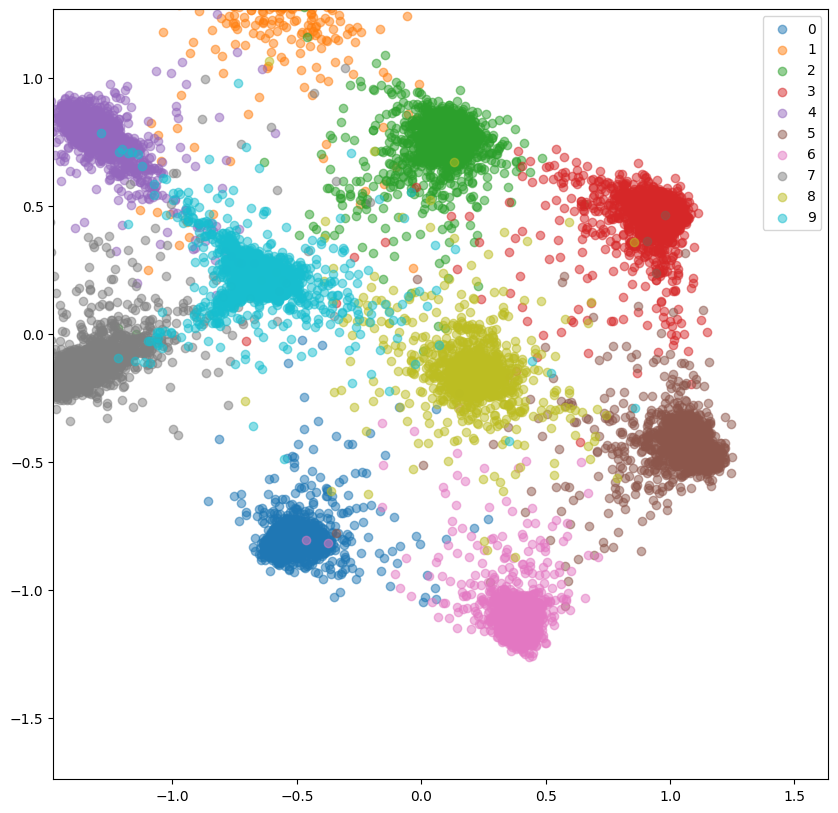

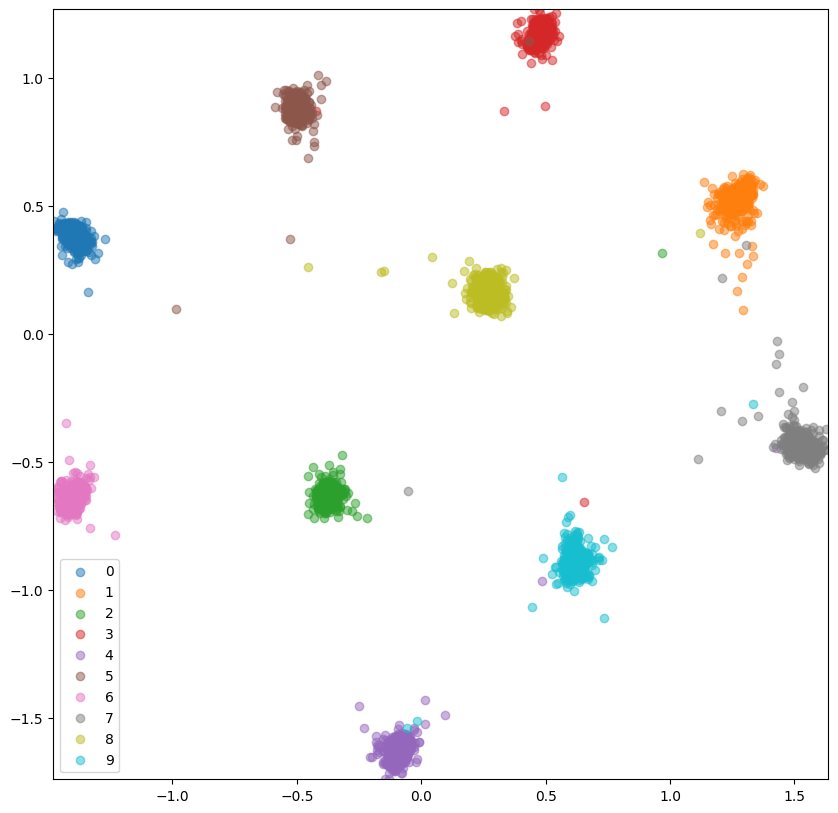

In [52]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)